### Stock Market Prediction And Forecasting Using Stacked LSTM

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
df = pd.read_csv('AAPL.csv')
df.head()

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,0,AAPL,2015-05-27 00:00:00+00:00,132.045,132.260,130.05,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
1,1,AAPL,2015-05-28 00:00:00+00:00,131.780,131.950,131.10,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0
2,2,AAPL,2015-05-29 00:00:00+00:00,130.280,131.450,129.90,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1.0
3,3,AAPL,2015-06-01 00:00:00+00:00,130.535,131.390,130.05,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0,1.0
4,4,AAPL,2015-06-02 00:00:00+00:00,129.960,130.655,129.32,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0,1.0


In [2]:
X = df.reset_index()['close']
X

0       132.045
1       131.780
2       130.280
3       130.535
4       129.960
         ...   
1253    314.960
1254    313.140
1255    319.230
1256    316.850
1257    318.890
Name: close, Length: 1258, dtype: float64

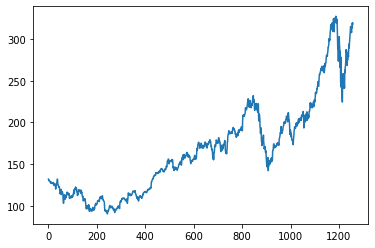

In [3]:
plt.plot(X)

In [4]:
X[0:5]

0    132.045
1    131.780
2    130.280
3    130.535
4    129.960
Name: close, dtype: float64

In [5]:
# LSTM are sensitive to the scale of the data. so we apply MinMax scaler 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(np.array(X).reshape(-1,1))
X[0:5]

array([[0.17607447],
       [0.17495567],
       [0.16862282],
       [0.1696994 ],
       [0.16727181]])

In [6]:
# splitting dataset into train and test split
# we should not do train_test_split because it will split randomly
# lstm needs continuous data so we are dividing manually
training_size = int(len(X)*0.65)
test_size = len(X)-training_size
train_data, test_data = X[0:training_size, :], X[training_size:len(X), :]

In [7]:
training_size, test_size

(817, 441)

In [8]:
train_data.shape, test_data.shape

((817, 1), (441, 1))

In [9]:
train_data[0:5]

array([[0.17607447],
       [0.17495567],
       [0.16862282],
       [0.1696994 ],
       [0.16727181]])

In [10]:
X[0:5]

array([[0.17607447],
       [0.17495567],
       [0.16862282],
       [0.1696994 ],
       [0.16727181]])

In [11]:
# 1, 2, 3, 4, 5, 6 -train_data
# time_stamps = 2
# 1, 2 - 3
# 2, 3 - 4
# 3, 4 - 5
# 4, 5 - 6 # the last sample of train_data and last sample of y_train are same

In [12]:
X[0:2, :]

array([[0.17607447],
       [0.17495567]])

In [13]:
X[0:2, :].reshape(-1)

array([0.17607447, 0.17495567])

In [14]:
X[0, :]

array([0.17607447])

In [15]:
X[0, :][0]

0.1760744743730473

In [16]:
# converting array into X_train, y_train
def create_dataset(X, time_step):
    dataX, datay = [], []
    for i in range(len(X)-time_step):
        x1 = X[i:(i+time_step), :].reshape(-1)    
        y1 = X[(i+time_step), :][0]
        dataX.append(x1)
        datay.append(y1)
    return np.array(dataX), np.array(datay)

In [17]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [18]:
train_data[len(train_data)-1]

array([0.52647133])

In [19]:
y_train[len(y_train)-1]

0.5264713332770414

In [20]:
train_data[len(train_data)-1] == y_train[len(y_train)-1]

array([ True])

In [21]:
X_train.shape, y_train.shape

((717, 100), (717,))

In [22]:
X_test.shape, y_test.shape

((341, 100), (341,))

In [23]:
# reshape input to be [samples, time steps, features] which is required for LSTM
# the input for lstm is 3dimensional
X_train =X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [24]:
# Creating the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [25]:
model=Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100,1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [26]:
# for each training sample of dim (100, 1) the output shape is (100, 50) of first lstm layer
# the output for 2nd lstm layer is also (100, 50)
# the output for 3rd lstm layer is (100,)
# the output of dense layer is 1

In [27]:
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
12/12 [==============================] - 20s 530ms/step - loss: 0.0222 - val_loss: 0.0569
Epoch 2/100
12/12 [==============================] - 1s 46ms/step - loss: 0.0037 - val_loss: 0.0044
Epoch 3/100
12/12 [==============================] - 1s 55ms/step - loss: 0.0010 - val_loss: 0.0082
Epoch 4/100
12/12 [==============================] - 1s 78ms/step - loss: 8.0541e-04 - val_loss: 0.0039
Epoch 5/100
12/12 [==============================] - 1s 85ms/step - loss: 5.9467e-04 - val_loss: 0.0044
Epoch 6/100
12/12 [==============================] - 1s 54ms/step - loss: 6.4515e-04 - val_loss: 0.0038
Epoch 7/100
12/12 [==============================] - 1s 78ms/step - loss: 5.8398e-04 - val_loss: 0.0038
Epoch 8/100
12/12 [==============================] - 1s 47ms/step - loss: 5.7976e-04 - val_loss: 0.0039
Epoch 9/100
12/12 [==============================] - 1s 50ms/step - loss: 5.7154e-04 - val_loss: 0.0038
Epoch 10/100
12/12 [==============================] - 1s 47ms/step - loss:

12/12 [==============================] - 1s 51ms/step - loss: 1.9578e-04 - val_loss: 0.0011
Epoch 80/100
12/12 [==============================] - 1s 55ms/step - loss: 2.1336e-04 - val_loss: 0.0013
Epoch 81/100
12/12 [==============================] - 1s 84ms/step - loss: 1.8276e-04 - val_loss: 0.0010
Epoch 82/100
12/12 [==============================] - 1s 60ms/step - loss: 1.7972e-04 - val_loss: 0.0010
Epoch 83/100
12/12 [==============================] - 1s 94ms/step - loss: 1.6505e-04 - val_loss: 0.0010
Epoch 84/100
12/12 [==============================] - 1s 88ms/step - loss: 1.7849e-04 - val_loss: 9.8359e-04
Epoch 85/100
12/12 [==============================] - 1s 97ms/step - loss: 1.5627e-04 - val_loss: 9.5342e-04
Epoch 86/100
12/12 [==============================] - 1s 91ms/step - loss: 1.6541e-04 - val_loss: 9.5938e-04
Epoch 87/100
12/12 [==============================] - 1s 48ms/step - loss: 1.7162e-04 - val_loss: 9.3459e-04
Epoch 88/100
12/12 [==============================] 

In [28]:
# since the above training is not classification so there is no accuracy

In [29]:
X_train.shape

(717, 100, 1)

In [30]:
# Lets Do the prediction and check performance metrics
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [31]:
train_predict[0:5]

array([[0.09213227],
       [0.09174249],
       [0.09144688],
       [0.09261272],
       [0.09492974]], dtype=float32)

In [32]:
test_predict[0:5]

array([[0.27217233],
       [0.27421206],
       [0.27771172],
       [0.282173  ],
       [0.28288108]], dtype=float32)

In [33]:
train_predict.shape, test_predict.shape

((717, 1), (341, 1))

In [34]:
train_data.shape, test_data.shape

((817, 1), (441, 1))

In [35]:
X.shape

(1258, 1)

In [36]:
# since we are training the scaled values now we should retransfrom the scaled values to orginal val
# Transformback to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [37]:
train_predict[0:5]

array([[112.162445],
       [112.07012 ],
       [112.00011 ],
       [112.27625 ],
       [112.82506 ]], dtype=float32)

In [38]:
test_predict[0:5]

array([[154.80673],
       [155.28987],
       [156.1188 ],
       [157.1755 ],
       [157.34322]], dtype=float32)

In [39]:
# Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

142.9276991084225

In [40]:
# Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

240.27491073606555

In [41]:
train_predict.shape, test_predict.shape

((717, 1), (341, 1))

In [42]:
train_data.shape, test_data.shape

((817, 1), (441, 1))

In [43]:
X.shape

(1258, 1)

In [44]:
X[101:817].shape

(716, 1)

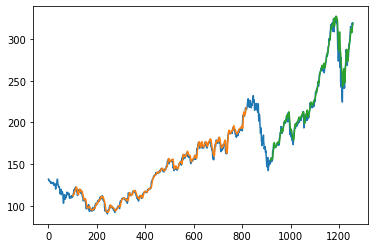

In [45]:
# Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(X)
trainPredictPlot[:, :] = np.nan
# indexing starts from 0
# 0-99(100 values) so we will start filling values from 100 index till 816 index
trainPredictPlot[100:817, :] = train_predict


# shift test predictions for plotting
testPredictPlot = np.empty_like(X)
testPredictPlot[:, :] = np.nan
testPredictPlot[817+100:1258, :] = test_predict


# plot baseline and predictions
plt.plot(scaler.inverse_transform(X))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

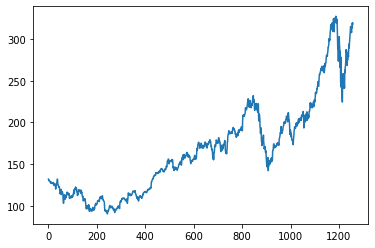

In [46]:
# plot baseline and predictions
# these are combined predictions of train_data and test_data
plt.plot(scaler.inverse_transform(X))
plt.show()

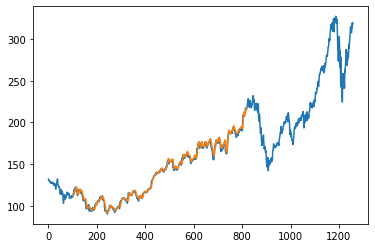

In [47]:
# predictions of training data
plt.plot(scaler.inverse_transform(X))
plt.plot(trainPredictPlot)

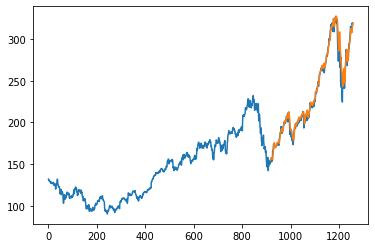

In [48]:
# predictions of test data which our model did not see
plt.plot(scaler.inverse_transform(X))
plt.plot(testPredictPlot)
plt.show()

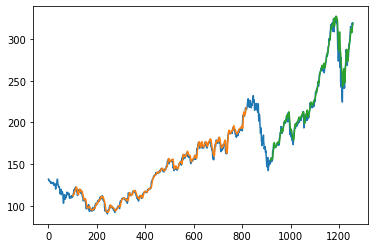

In [49]:
# predicting both training and testing data
plt.plot(scaler.inverse_transform(X))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [50]:
test_data.shape

(441, 1)

In [51]:
# values exist till 440 not 441
x_input = test_data[341:441].reshape(1,-1)
x_input.shape

(1, 100)

In [52]:
temp_input = list(x_input[0])
temp_input[0:5]

[0.8583551465000423,
 0.8866418981676942,
 0.8743139407244789,
 0.8843198513890065,
 0.8783669678290975]

In [53]:
# demonstrate prediction for next 30 days of test data
x_input = test_data[341:441].reshape(1,-1)
temp_input = list(x_input[0])
lst_output = []
n_steps = 100
i = 0
while (i<30): # starts from 0 ends at 29 so total 30 values
    
    if(len(temp_input)>100):
        x_input = np.array(temp_input[i:])
        # here 1st 1 is no, of samples
        # next 2 are dimensions of input
        x_input = x_input.reshape((1, 100, 1))
        y_pred = model.predict(x_input)

        temp_input.append(y_pred[0][0])
        lst_output.append(y_pred[0][0])
        
    else:
        # predicting one by one
        x_input = x_input.reshape((1, 100, 1))
        y_pred = model.predict(x_input)
        # tolist() converts to list datatype
        temp_input.append(y_pred[0][0])
        lst_output.append(y_pred[0][0])
    
    i = i+1
    
lst_output = np.array(lst_output).reshape(-1, 1)


In [54]:
lst_output.shape

(30, 1)

In [55]:
X.shape

(1258, 1)

In [56]:
day_new = np.arange(1,101)
day_pred = np.arange(101,131)

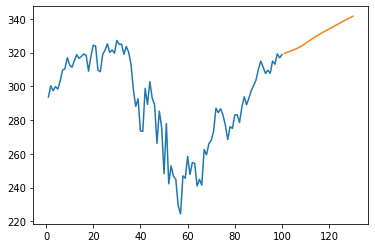

In [57]:
plt.plot(day_new, scaler.inverse_transform(X[1158:]))
plt.plot(day_pred, scaler.inverse_transform(lst_output))